In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [ ]:
!pip install catboost

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import RocCurveDisplay

from catboost import CatBoostRegressor
from catboost import cv, Pool

import time
from joblib import dump

In [31]:
def fit_eval(clf, X_train, y_train, X_test, y_test, name):
    print(f"Fitting {name} ...")
    start_tic = time.time()
    clf.fit(X_train, y_train)
    print(f"Fitting takes: {(time.time() - start_tic):.3f} s")
    
    # Get the best classifier from the grid search
    # best_clf_rf = grid_search.best_estimator_
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate ROC AUC score
    # roc_auc = roc_auc_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # print("ROC AUC Score:", roc_auc)
    print("R^2 score:", r2)
    print("Adjust R^2 score:", 1-(1-r2)*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

    # display = RocCurveDisplay.from_predictions(
    #     y_test,
    #     y_pred,
    #     color="darkorange")
    
    # _ = display.ax_.set(
    #     xlabel="False Positive Rate",
    #     ylabel="True Positive Rate",
    #     title=f"{name} ROC curve:",
        
    # )
    
    return clf

In [20]:
train_data = pd.read_csv("data/train_wo_aug_set.csv")
test_data = pd.read_csv("data/test_wo_aug_set.csv")

# train_aug_data = pd.read_csv("data/train_set.csv")
# test_aug_data = pd.read_csv("data/test_set.csv")

In [23]:
indexes = [
    "h_l",
    "all",
]

names = [
    "RF",
    "GBoost",
    "CatBoost",
    "RBF-SVM",
    "MLP-1L",
    "MLP-2L_s",
    "MLP-2L_L",
]

classifiers = [
    RandomForestRegressor(max_depth=10, 
                           min_samples_leaf=4, min_samples_split=10, 
                           n_estimators=200, random_state=42),
    GradientBoostingRegressor(random_state=0),
    CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10),
    SVR(gamma='auto'),
    MLPRegressor(hidden_layer_sizes=(128), 
                  max_iter=1500, random_state=42),
    MLPRegressor(hidden_layer_sizes=(128, 32), 
                  max_iter=1000, random_state=42),
    MLPRegressor(hidden_layer_sizes=(256, 64), 
                  max_iter=1000, random_state=42),
]


datasets = [
    [train_data.drop(["growth"], axis=1).to_numpy(), test_data.drop(["growth"], axis=1).to_numpy(),
     train_data["growth"].to_numpy(), test_data["growth"].to_numpy(), "wo_aug"],
    # [train_aug_data.drop(["mark"], axis=1).to_numpy(), test_aug_data.drop(["mark"], axis=1).to_numpy(),
    #  train_aug_data["mark"].to_numpy(), test_aug_data["mark"].to_numpy(), "aug"],
]

In [32]:
dir = "../Modeling Piling-Ballon Mode/models/"  # "models/"

for ds_cnt, ds in enumerate(datasets):
    X_train, X_test, y_train, y_test, name_ds = ds

    X, y = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, clf in zip(names, classifiers):
        clf_pl_1 = make_pipeline(StandardScaler(), clf)
        fit_eval(clf_pl_1, X_train, y_train, X_test, y_test, name)
        
        clf_pl_2 = make_pipeline(StandardScaler(), clf)
        fit_eval(clf_pl_2, X_train_, y_train_, X_test_, y_test_, name)

        dump(clf_pl_1, f'{dir}{name}-{name_ds}-{indexes[0]}.joblib')
        dump(clf_pl_2, f'{dir}{name}-{name_ds}-{indexes[1]}.joblib')

Fitting RF ...
Fitting takes: 0.265 s
R^2 score: 0.7300078049980903
Adjust R^2 score: 0.7256647670087835
Fitting RF ...
Fitting takes: 0.271 s
R^2 score: 0.9786527389228806
Adjust R^2 score: 0.9780731752737281
Fitting GBoost ...
Fitting takes: 0.050 s
R^2 score: 0.7387638775685279
Adjust R^2 score: 0.7345616879315605
Fitting GBoost ...
Fitting takes: 0.058 s
R^2 score: 0.9879625146545178
Adjust R^2 score: 0.9876357050976269
Fitting CatBoost ...
0:	learn: 0.0462103	total: 139ms	remaining: 2m 18s
1:	learn: 0.0426621	total: 139ms	remaining: 1m 9s
2:	learn: 0.0394568	total: 141ms	remaining: 47s
3:	learn: 0.0365300	total: 142ms	remaining: 35.3s
4:	learn: 0.0338428	total: 143ms	remaining: 28.5s
5:	learn: 0.0313893	total: 144ms	remaining: 23.9s
6:	learn: 0.0291565	total: 145ms	remaining: 20.6s
7:	learn: 0.0271937	total: 145ms	remaining: 18s
8:	learn: 0.0252496	total: 146ms	remaining: 16.1s
9:	learn: 0.0237272	total: 146ms	remaining: 14.5s
10:	learn: 0.0220300	total: 147ms	remaining: 13.3s
11:

---
---

In [3]:
X_train, X_test, y_train, y_test = train_data.drop(["mark"], axis=1).to_numpy(), test_data.drop(["mark"], axis=1).to_numpy(), train_data["mark"].to_numpy(), test_data["mark"].to_numpy()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1725, 6) (875, 6) (1725,) (875,)


In [89]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf_rf = RandomForestClassifier(random_state=42)
clf_rf = clf_rf.set_params({'max_depth': 10,'min_samples_leaf': 4,'min_samples_split': 10,'n_estimators': 200})
# grid_search = GridSearchCV(clf_rf, param_grid, cv=5, scoring='roc_auc')

clf_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, random_state=42))

print("Fitting RFC...")
start_tic = time.time()
clf_rf.fit(X_train_, y_train_)
print(f"Fitting takes: {(time.time() - start_tic):.3f} s")

# Get the best classifier from the grid search
# best_clf_rf = grid_search.best_estimator_

# Make predictions
y_pred_proba = clf_rf.predict_proba(X_test_)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Fitting RFC...
Fitting takes: 0.408 s
ROC AUC Score: 0.9939713515999737


In [10]:
# grid_search.best_params_

# {'max_depth': 10,
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'n_estimators': 200}

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [5]:
clf_linear = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True, random_state=42))
clf_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, random_state=42))
clf_poly = make_pipeline(StandardScaler(), SVC(kernel="poly", probability=True, random_state=42))

In [86]:
print("Fitting RBF SVM...")
start_tic = time.time()
clf_rbf.fit(X_train_, y_train_)
print(f"Fitting takes: {(time.time() - start_tic):.3f} s")

print("Pedicting...")
y_pred_proba = clf_rbf.predict_proba(X_test_)[:, 1]

roc_auc = roc_auc_score(y_test_, y_pred_proba)
print("ROC AUC Score:", roc_auc)
print("-----")

display = RocCurveDisplay.from_predictions(
    y_test_,
    y_pred_proba,
    color="darkorange")

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve:",
)

Fitting RBF SVM...
Fitting takes: 0.597 s
Pedicting...
ROC AUC Score: 0.9033362901636113
-----


In [83]:
clf_mlp = make_pipeline(StandardScaler(), 
                        MLPClassifier(hidden_layer_sizes=(256, 64), max_iter=1000, random_state=42))
# , early_stopping=True

X, y = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

print("Fitting MLP Classifier...")
start_tic = time.time()
clf_mlp.fit(X_train_, y_train_)
print(f"Fitting takes: {(time.time() - start_tic):.3f} s")

print("Pedicting...")
y_pred_proba = clf_mlp.predict_proba(X_test_)[:, 1]

roc_auc = roc_auc_score(y_test_, y_pred_proba)
print("ROC AUC Score:", roc_auc)
print("-----")

Fitting MLP Classifier...
Fitting takes: 3.935 s
Pedicting...
ROC AUC Score: 0.9931992903607333
-----


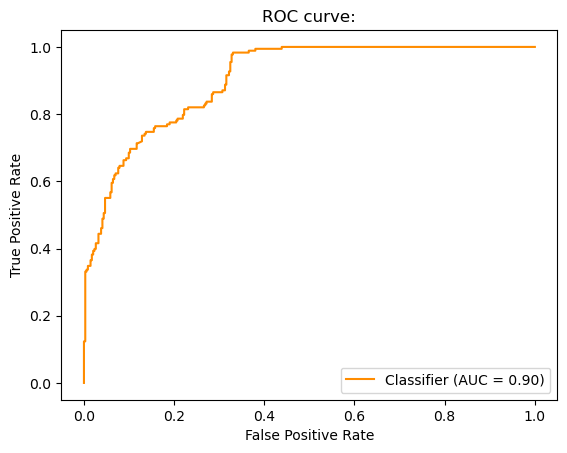

In [87]:
display = RocCurveDisplay.from_predictions(
    y_test_,
    y_pred_proba,
    color="darkorange")

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve:",
)

---

In [85]:
from joblib import dump

index = 3
dump(clf_mlp, f'../Modeling Piling-Ballon Mode/models/MLP_classifier_{index}.joblib')

['../Modeling Piling-Ballon Mode/models/MLP_classifier_3.joblib']

In [90]:
from joblib import dump

dump(clf_rf, 'models/RF_classifier_2.joblib')
# dump(clf_rbf, 'models/RBF-SVM_classifier_2.joblib')
# dump(clf_poly, 'models/Poly-SVM_classifier.joblib')
# dump(clf_linear, 'models/Linear-SVM_classifier.joblib')

['models/RF_classifier_2.joblib']